# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

The goal of this project is to run various time series models on the taxi orders data to go an estimate of how many orders will be placed in the next hour.  We are going to clean up the data (make sure ther is no NaN's or outliers) then combine the data into 1 hour time frames instead of 10 minutes time frames.  Our goal for the models is to train one with an RMSE below 48 to get the most accurate model possible.  

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


<AxesSubplot:>

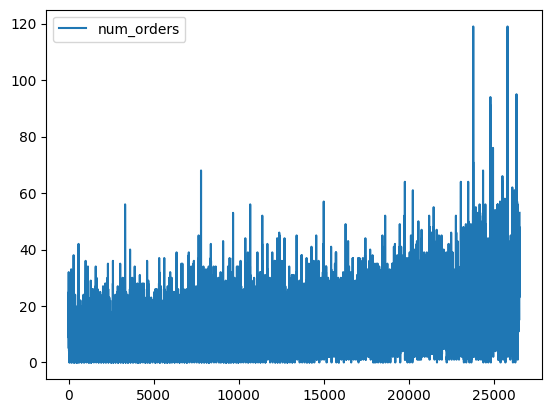

In [1]:
#Importing data sets and analyzing the information for outliers or NaN values
import pandas as pd

taxi = pd.read_csv('/datasets/taxi.csv')

print(taxi.describe())
print()
print(taxi.info())

taxi.plot()

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


<AxesSubplot:xlabel='datetime'>

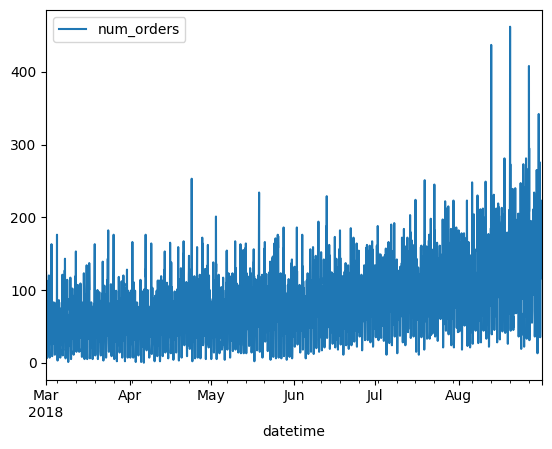

In [2]:
#Resampling data into 1hr time frames
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.set_index('datetime', inplace=True)
taxi = taxi.resample('H').sum() 

#Reanalyze info
print(taxi.describe())
print()
print(taxi.info())

taxi.plot()

## Analysis

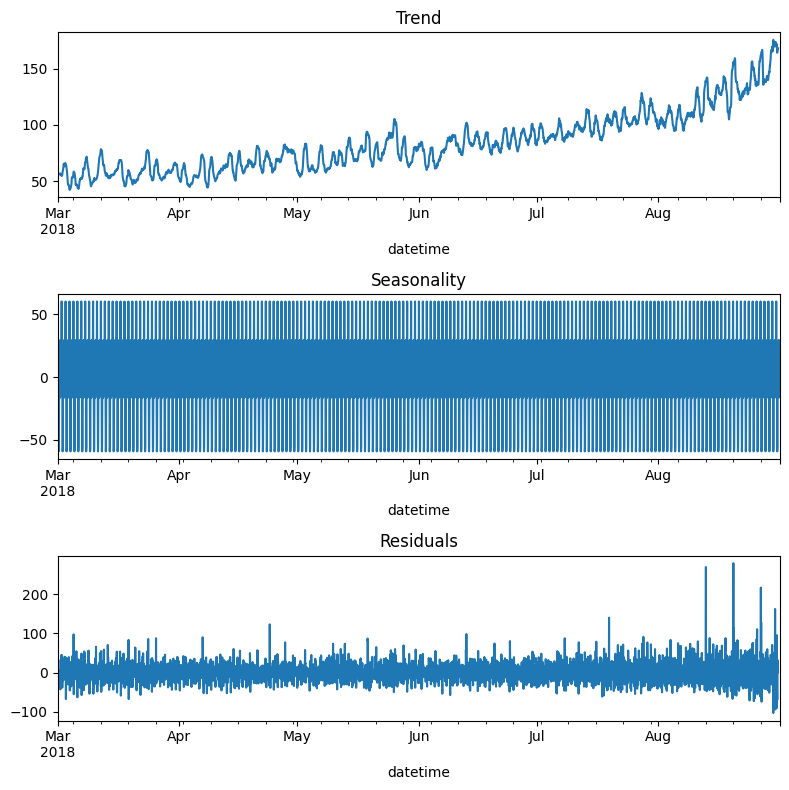

In [3]:
#Analyzing seasonality, trends, residuals
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

#The trend appears to be rising increasing as taxi orders probably increase throughout the year into the summer as more people are traveling.  The residuals are also larger towards the end of the plot as well.  The seasonality graph is impossible to read because of to many data points, I am going to trim the data down into a one month time frame a replot to see what the weekly seasonanilty trends look like.

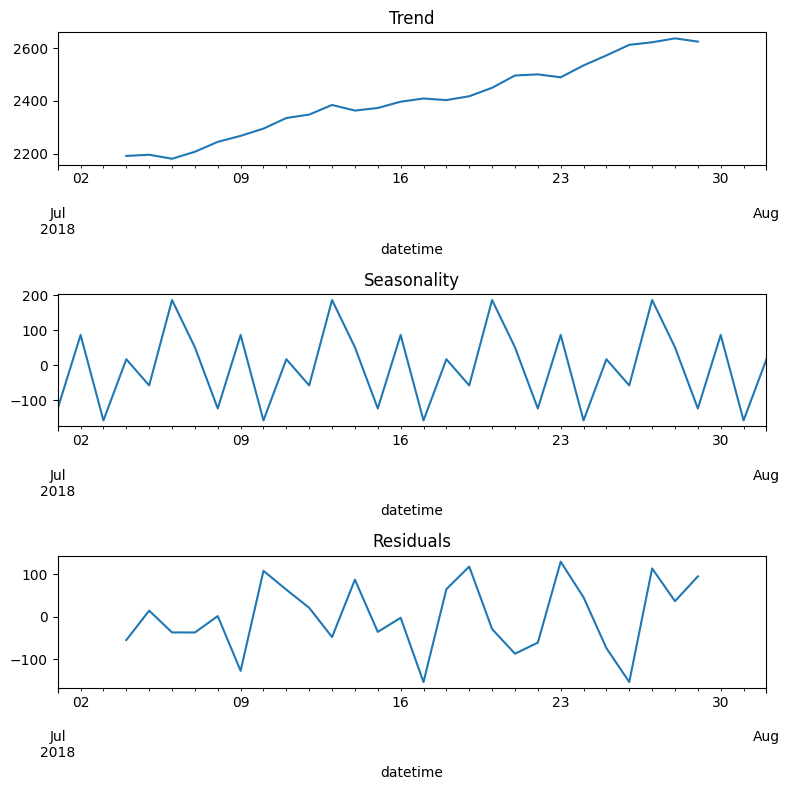

In [4]:
#Analyzing to see if there is weekly trends
start_date = '2018-07-01'
end_date = '2018-08-01'

july_data = taxi.loc[start_date:end_date]
july_data = july_data.resample('D').sum() 
decompose_july = seasonal_decompose(july_data, model='additive', period=7)


plt.figure(figsize=(8, 8))
plt.subplot(311)
decompose_july.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decompose_july.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decompose_july.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

#Based off the smaller plot there is clearly a daily trend with the highest days probably being Monday and Friday as the highest points are days 6, 13, 20 and 27 then the next highest ones are 2, 9, 16, 23.  

#From looking at the data it appears to be nonstationary but I am going to double check by running the Dickey-Fuller test.

In [5]:
#Running Dickey-Fuller test to see if our data is stationary
from statsmodels.tsa.stattools import adfuller
taxi_stationary_test = adfuller(taxi['num_orders'], autolag='AIC')
print("P-value:", taxi_stationary_test[1])

P-value: 0.028940051402613028


According to our Dickey Fuller test the data is actually stationary, knowing this will help us with our analysis going forward.

## Training

In [6]:
#Predicting number of orders for the next hour using a constant
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

train, test = train_test_split(taxi, test_size=0.1, shuffle=False)

pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse = np.sqrt(mean_squared_error(test['num_orders'], pred_median))

print('RMSE:', rmse)

RMSE: 87.15277582981295


The mmodel using the MAE gave us an MAE of 87.15 which is fairly high and above our requirement of 48.  The model was expected to score high since there is not many parameters and its not looking at seasonality or anything.

In [7]:
#Creating day of week column
taxi_extended = taxi
taxi_extended['day_of_week'] = taxi.index.dayofweek

print(taxi_extended.info())
print(taxi_extended.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   num_orders   4416 non-null   int64
 1   day_of_week  4416 non-null   int64
dtypes: int64(2)
memory usage: 232.5 KB
None
        num_orders  day_of_week
count  4416.000000  4416.000000
mean     84.422781     3.005435
std      45.023853     1.990684
min       0.000000     0.000000
25%      54.000000     1.000000
50%      78.000000     3.000000
75%     107.000000     5.000000
max     462.000000     6.000000


I am going to add an additional day of the week feature then run the model for a lag and rolling mean to calculate the MAE with that information and new parameters.

In [8]:
from sklearn.linear_model import LinearRegression

taxi_extended = taxi

def make_features(taxi_extended, max_lag, rolling_mean_size):
    taxi_extended['day_of_week'] = taxi_extended.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi_extended['lag_{}'.format(lag)] = taxi_extended['num_orders'].shift(lag)
        
    taxi_extended['rolling_mean'] = (taxi_extended['num_orders'].shift().rolling(rolling_mean_size).mean())
    
make_features(taxi_extended, 6, 10)
train, test = train_test_split(taxi_extended, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print('RMSE for the training set:', np.sqrt(mean_squared_error(target_train, pred_train)))
print('RMSE for the test set:', np.sqrt(mean_squared_error(target_test, pred_test)))

RMSE for the training set: 31.51601112077062
RMSE for the test set: 54.29531677464363


Using parameters for max lag and rolling mean size gave us an improved model compared the constant median one we used prior.  The RMSE for the test set was 54.3, which is above our goal of 48.  Next we will be using autoregression models for our hourly predictions.  I will be using the AR select order to find the optimal number of lags for our model. 

In [9]:
import warnings
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
print(taxi.info())
warnings.filterwarnings('ignore')

# find optimal number of lags
mod = ar_select_order(endog=train['num_orders'], maxlag=30)
ar_order = mod.ar_lags

# create AR model and fit it using the training set
ar_model = AutoReg(train['num_orders'], lags=ar_order, seasonal=True, period=168)
ar_model = ar_model.fit()

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# evaluate model
ar_rmse_value = np.sqrt(mean_squared_error(test['num_orders'], ar_pred)) # fill in the code to calculate MAE
print("RMSE Value:", ar_rmse_value.round(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day_of_week   4416 non-null   int64  
 2   lag_1         4415 non-null   float64
 3   lag_2         4414 non-null   float64
 4   lag_3         4413 non-null   float64
 5   lag_4         4412 non-null   float64
 6   lag_5         4411 non-null   float64
 7   lag_6         4410 non-null   float64
 8   rolling_mean  4406 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 474.0 KB
None
RMSE Value: 53.077


Running the autoregression model improved our MAE on the test set slightly as it spit out an RMSE of 53.1.  Which is the best performing model we have had so far.  Next we will be using an ARIMA model to test how well it performs on this data.

In [10]:
print(taxi.info())
columns_to_drop = ['day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean']
taxi = taxi.drop(columns=columns_to_drop)
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day_of_week   4416 non-null   int64  
 2   lag_1         4415 non-null   float64
 3   lag_2         4414 non-null   float64
 4   lag_3         4413 non-null   float64
 5   lag_4         4412 non-null   float64
 6   lag_5         4411 non-null   float64
 7   lag_6         4410 non-null   float64
 8   rolling_mean  4406 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 474.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB
None


In [11]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(taxi, shuffle=False, test_size=0.10)

ar_order = 5
d = 2
ma_order = 1
arma_full_order = (ar_order, d, ma_order)

arma_model = ARIMA(train, order=arma_full_order)
arma_model = arma_model.fit()
predictions = arma_model.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print("RMSE Value:", arima_rmse)

RMSE Value: 60.338514252734335


The ARIMA model did fairly well for the MAE on our test data getting a 60 (slightly above our goal of a 48).  It did not perform as well as our autoregression model, for our next step we will use autoarima to try to find the best parameters for the ARIMA model and see if that imporves the MAE score.

In [12]:
from pmdarima import auto_arima

model = auto_arima(test, start_p=0, max_p=10, start_q=0, max_q=10, start_d=0, max_d=10, seasonal=True, stepwise=False, trace=True)

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4850.652, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4818.173, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4824.922, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4825.323, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=4813.214, Time=0.20 sec

In [13]:
#Since AUTO ARIMA Spit out the SARIMAX best model to be (5, 1, 0) we are going to use those parameters and test the MAE.
p = 5
d = 1
q = 0
arma_full_order = (p, d, q)

model = ARIMA(train, order=arma_full_order)
model = model.fit()
predictions = model.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print(arima_rmse)

61.54402689978738


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

train = train.sort_index()  

max_lag = 28

for i in range(1, max_lag + 1):
    train[f'lag{i}'] = train['num_orders'].shift(i)

train.dropna(inplace=True)

lag_cols = [f'lag{i}' for i in range(1, max_lag + 1)]

X = train[lag_cols]
y = train['num_orders']    

test_size = int(len(X) * 0.1)
tscv = TimeSeriesSplit(n_splits=2, test_size=test_size) 

param_grid = {
    'n_estimators': [25, 50, 100, 250],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

rf = RandomForestRegressor(random_state=12345)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer, 
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_ 

print("Best Parameters:", best_params)
print("Best Actual RMSE:", -best_score)  


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}
Best Actual RMSE: 32.34625927500293


In [19]:
test = test.sort_index()

for i in range(1, max_lag + 1):
    test[f'lag{i}'] = test['num_orders'].shift(i)
    
test.dropna(inplace=True)

X_test = test[lag_cols]
y_test = test['num_orders']

test_predictions = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Test RMSE:", test_rmse)

Test RMSE: 44.37530385864832


## Testing

After running the random forest classifier with 14 lagged variables and param grid I was able to get an RMSE score below 48.  I chose 14 lags because that would give us two weeks of data for the model to visualize how the weekly trends go.  I could of extended it longer for even more accuracy if I had to guess.  In the end the random forest classifier model performed the best at predicting the data with an RMSE of 45.4 and the following parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250}.  Each model slowly improved its score as we added more hyperparameter tuning and additional variables to look at.  Once we ran our best model on the test data we got an even better RMSE score of 16.7.  A very well performing model and far better than our goal of 48.

# Review checklist

- [x]  Jupyter Notebook is open
- [X]  The code is error-free
- [X]  The cells with the code have been arranged in order of execution
- [X]  The data has been downloaded and prepared
- [X]  The data has been analyzed
- [X]  The model has been trained and hyperparameters have been selected
- [X]  The models have been evaluated. Conclusion has been provided
- [X] *RMSE* for the test set is not more than 48